In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import gc
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from IPython.lib.display import Audio
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_curve,
)
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    Input,
    MaxPool1D,
)

2024-05-05 17:37:43.830704: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-05 17:37:43.859593: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 17:37:43.859618: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 17:37:43.859623: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-05 17:37:43.863972: I tensorflow/core/platform/cpu_feature_g

In [3]:
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=8000)],
)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-05 17:37:45.484356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:37:45.504438: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:37:45.504619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
emotion_list = {
    0: "neutral",
    1: "calm",
    2: "happy",
    3: "sad",
    4: "angry",
    5: "fearful",
    6: "disgusted",
    7: "surprised",
}

In [5]:
def plot_network_history(network_history):
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].plot(network_history.history["loss"], label="Training Loss")
    axes[0].plot(network_history.history["val_loss"], label="Validation Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    axes[1].plot(network_history.history["categorical_accuracy"], label="Training Categorical Accuracy")
    axes[1].plot(network_history.history["val_categorical_accuracy"], label="Validation Categorical Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()
    plt.show()

In [6]:
with open("./data/processed_data.pickle", "rb") as f:
    data = pickle.load(f)
X_train = data["X_train"]
X_test = data["X_test"]
Y_train = data["Y_train"]
Y_test = data["Y_test"]

In [7]:
X_train.shape

(12000, 40, 1)

In [8]:
print(gc.collect())
K.clear_session()

num_classes = len(Y_test[0])
model = Sequential()

layers = [
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(1024),
    Dense(num_classes, activation="softmax"),
]

model = tf.keras.Sequential(layers)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

model.summary()

47


2024-05-05 17:37:45.731253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:37:45.731511: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-05 17:37:45.731633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1024)              4202496   
                                                                 
 dense (Dense)               (None, 8)                 8200      
                                                                 
Total params: 4210696 (16.06 MB)
Trainable params: 4210696 (16.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
es = keras.callbacks.EarlyStopping(
    monitor="val_categorical_accuracy", min_delta=0.00005, patience=10, restore_best_weights=True
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor="val_categorical_accuracy",
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)


network_history = model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=64,
    validation_split=0.2,
    callbacks=[es, lr_scheduler],
)

Epoch 1/100
  1/150 [..............................] - ETA: 3:28 - loss: 2.0858 - categorical_accuracy: 0.0469

2024-05-05 17:37:48.491273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-05-05 17:37:48.536151: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7605e8dbfe20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-05 17:37:48.536174: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-05-05 17:37:48.539144: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-05 17:37:48.599688: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 [==============================] - 4s 18ms/step - loss: 1.9310 - categorical_accuracy: 0.2453 - val_loss: 1.8183 - val_categorical_accuracy: 0.2879 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 2s 15ms/step - loss: 1.7916 - categorical_accuracy: 0.2999 - val_loss: 1.7047 - val_categorical_accuracy: 0.3404 - lr: 0.0010
Epoch 3/100
150/150 [==============================] - 2s 15ms/step - loss: 1.6934 - categorical_accuracy: 0.3464 - val_loss: 1.6634 - val_categorical_accuracy: 0.3542 - lr: 0.0010
Epoch 4/100
150/150 [==============================] - 2s 15ms/step - loss: 1.6228 - categorical_accuracy: 0.3802 - val_loss: 1.6212 - val_categorical_accuracy: 0.3679 - lr: 0.0010
Epoch 5/100
150/150 [==============================] - 2s 15ms/step - loss: 1.5672 - categorical_accuracy: 0.3995 - val_loss: 1.5581 - val_categorical_accuracy: 0.4075 - lr: 0.0010
Epoch 6/100
150/150 [==============================] - 2s 15ms/step - loss: 1.5164 - categorical_accuracy: 

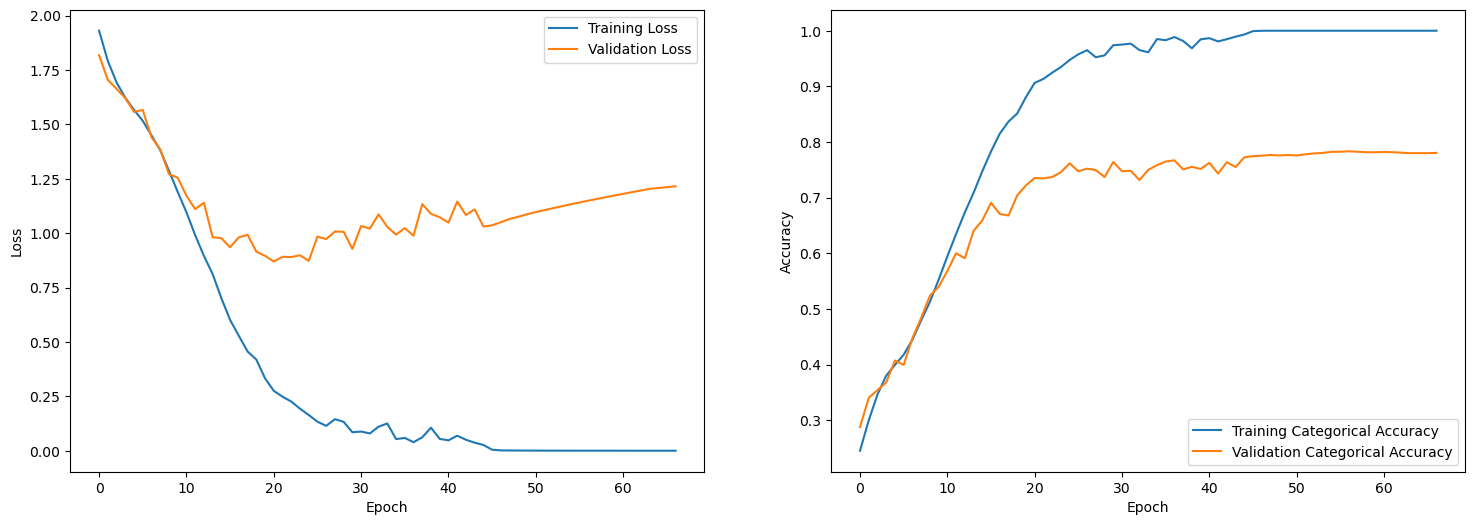

In [10]:
plot_network_history(network_history)

In [11]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
preds = model.predict(X_test)

9/9 [==============================] - 0s 4ms/step


In [12]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, 1)
y_true = np.argmax(Y_test, 1)

print("Test accuracy: %g" % (accuracy_score(y_true, y_pred)))
print("Precision", precision_score(y_true, y_pred, average="macro"))
print("Recall", recall_score(y_true, y_pred, average="macro"))
print("f1_score", f1_score(y_true, y_pred, average="macro"))

9/9 [==============================] - 0s 4ms/step
Test accuracy: 0.5
Precision 0.5001338959352744
Recall 0.4914000618224497
f1_score 0.4934915254449884


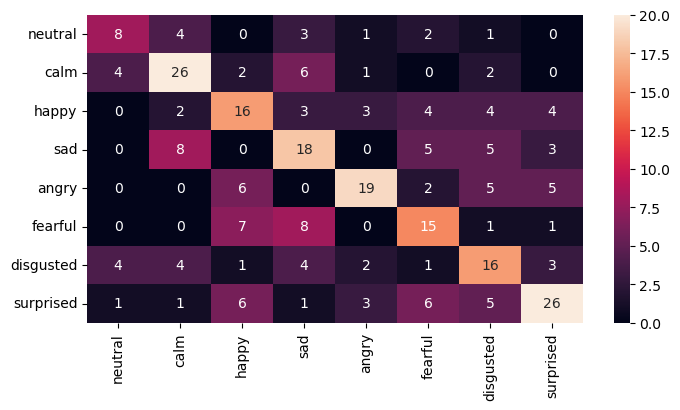

In [13]:
plt.figure(figsize=(8, 4))
conf = confusion_matrix(y_true, y_pred)
labels = emotion_list.values()
sns.heatmap(conf, annot=True, fmt="d", vmax=20, xticklabels=labels, yticklabels=labels)
plt.show()